In [1]:
# --- Standard Library & General Science ---
import warnings
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import eigh
from scipy.optimize import minimize
from scipy.sparse import dok_matrix, csr_matrix
from scipy.sparse.linalg import eigsh
from IPython.display import display

# --- Graph Theory & Visualization ---
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

# --- Quantum Chemistry & Simulation (Non-Qiskit) ---
import pyscf
import pyscf.cc
import pyscf.mcscf
from pyscf import ao2mo, gto, mcscf, scf

# --- Qiskit: Core & Circuit ---
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import EfficientSU2, TwoLocal, efficient_su2
from qiskit.circuit.library import (
    RXXGate, RYYGate, RZZGate, RZGate,
    QAOAAnsatz, PauliEvolutionGate
)
from qiskit.synthesis import LieTrotter
from qiskit.quantum_info import SparsePauliOp, Statevector

# --- Qiskit: Quantum Information ---
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator

# --- Qiskit: Transpiler & Providers ---
from qiskit.transpiler import Layout, CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator

# --- Qiskit: Primitives & Runtime ---
from qiskit.primitives import StatevectorEstimator
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)
from qiskit_ibm_runtime.debug_tools import Neat

# --- Qiskit: Visualization ---
from qiskit.visualization import plot_histogram
# Qiskit Nature
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
from qiskit_nature.second_q.problems import LatticeModelProblem
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.hamiltonians.lattices import BoundaryCondition, LineLattice
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC
from qiskit_nature.second_q.operators import FermionicOp

# Qiskit Algorithms & Solvers
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import NumPyMinimumEigensolver

# Qiskit Primitives & Simulator
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_aer import AerSimulator

In [2]:
# --- 1. HAMILTONIAN (2x2) ---
def build_fermi_hubbard_2x2_op(t, U):
    num_sites = 4
    num_spin_orbitals = 2 * num_sites
    terms = {}
    def up_index(site): return 2 * site
    def down_index(site): return 2 * site + 1

    # Cạnh: (Ngang: 0-1, 2-3) & (Dọc: 0-2, 1-3)
    edges = [(0, 1), (2, 3), (0, 2), (1, 3)]

    for (i, j) in edges:
        p, q = up_index(i), up_index(j)
        terms[f"+_{p} -_{q}"] = terms.get(f"+_{p} -_{q}", 0.0) - t
        terms[f"+_{q} -_{p}"] = terms.get(f"+_{q} -_{p}", 0.0) - t
        p, q = down_index(i), down_index(j)
        terms[f"+_{p} -_{q}"] = terms.get(f"+_{p} -_{q}", 0.0) - t
        terms[f"+_{q} -_{p}"] = terms.get(f"+_{q} -_{p}", 0.0) - t

    for i in range(num_sites):
        u_idx, d_idx = up_index(i), down_index(i)
        op_str = f"+_{u_idx} -_{u_idx} +_{d_idx} -_{d_idx}"
        terms[op_str] = terms.get(op_str, 0.0) + U

    return FermionicOp(terms, num_spin_orbitals=num_spin_orbitals)

In [3]:
# --- 2. HEA ANSATZ CHO 2x2 ---
def create_2x2_hea_ansatz(reps=4):
    num_sites = 4
    num_qubits = 2 * num_sites
    qc = QuantumCircuit(num_qubits)

    # A. Khởi tạo trạng thái Néel (Checkerboard cho 2x2)

    qc.x([0, 3, 5, 6])
    qc.barrier()

    # B. Các lớp biến phân
    params_per_layer = 2 * num_qubits
    total_params = reps * params_per_layer
    theta = ParameterVector('θ', length=total_params)
    p_idx = 0

    for layer in range(reps):
        # 1. Rotation Layer (Ry, Rz)
        for q in range(num_qubits):
            qc.ry(theta[p_idx], q); p_idx += 1
            qc.rz(theta[p_idx], q); p_idx += 1

        # 2. Entangling Layer (Linear Chain CZ)
        for q in range(num_qubits - 1):
            qc.cz(q, q + 1)

        qc.barrier()

    return qc

--- FERMI-HUBBARD 2x2 (HEA) ---
Ansatz: HEA | Reps: 4
-------------------------------------------------------------------------------------
U/t        | VQE Energy      | Exact Energy    | Error     
-------------------------------------------------------------------------------------
0.0        | -3.999725       | -4.000000       | 0.000275  
1.0        | -1.561737       | -3.340848       | 1.779111  
2.0        | -1.235635       | -2.828427       | 1.592793  
4.0        | -0.000144       | -2.102748       | 2.102604  


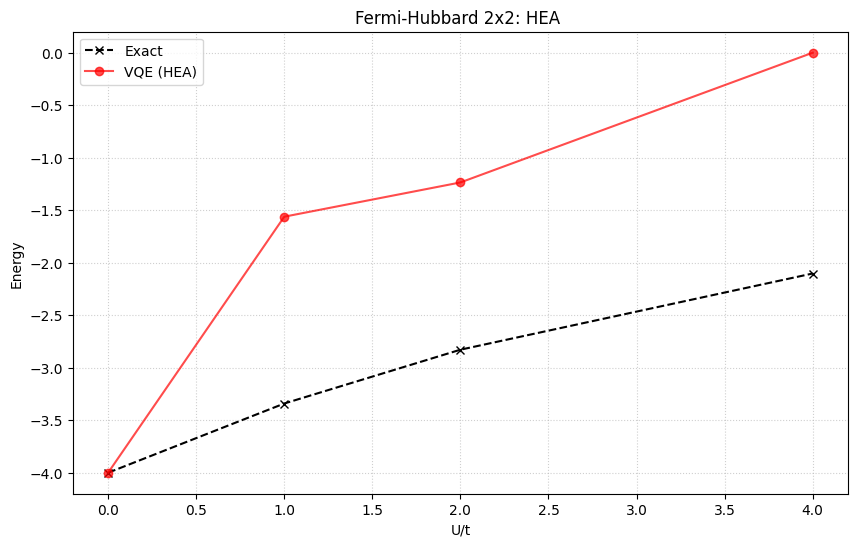

In [4]:
def main():
    t = 1.0
    U_values = [0.0, 1.0, 2.0, 4.0]
    reps = 4

    penalty_strength = 2.0
    target_particles = 4

    print(f"--- FERMI-HUBBARD 2x2 (HEA) ---")
    print(f"Ansatz: HEA | Reps: {reps}")
    print("-" * 85)
    print(f"{'U/t':<10} | {'VQE Energy':<15} | {'Exact Energy':<15} | {'Error':<10}")
    print("-" * 85)

    mapper = JordanWignerMapper()

    vqe_Es = []
    exact_Es = []
    prev_params = None

    # Toán tử số hạt (N)
    num_op_ferm = FermionicOp({f"+_{i} -_{i}": 1.0 for i in range(8)}, num_spin_orbitals=8)
    qubit_N = mapper.map(num_op_ferm)

    for U in U_values:
        # 1. Build Hamiltonian
        ferm_H = build_fermi_hubbard_2x2_op(t, U)
        qubit_H = mapper.map(ferm_H)

        # 2. Hamiltonian có Phạt
        H_with_penalty = qubit_H + penalty_strength * (qubit_N @ qubit_N - 2 * target_particles * qubit_N)

        # 3. Exact Solution
        filter_fn = lambda s, v, a: np.isclose(a['NumberOp'][0], target_particles, atol=1e-1)
        exact_res = NumPyMinimumEigensolver(filter_criterion=filter_fn).compute_minimum_eigenvalue(
            operator=qubit_H, aux_operators={'NumberOp': qubit_N}
        )
        exact_E = exact_res.eigenvalue.real
        exact_Es.append(exact_E)

        # 4. Run VQE
        ansatz = create_2x2_hea_ansatz(reps=reps)
        estimator = Estimator()

        def cost_func(params):
            job = estimator.run([(ansatz, H_with_penalty, params)])
            return job.result()[0].data.evs

        # --- KHỞI TẠO MẠNH ---
        num_params = ansatz.num_parameters
        initial_point = np.random.uniform(-0.5, 0.5, num_params)

        # Dùng SLSQP
        res = SLSQP(maxiter=5000, ftol=1e-04).minimize(cost_func, initial_point)

        # 5. Tính kết quả thực
        job_check = estimator.run([(ansatz, qubit_H, res.x), (ansatz, qubit_N, res.x)])
        check_res = job_check.result()
        vqe_E = check_res[0].data.evs
        n_particles = check_res[1].data.evs

        vqe_Es.append(vqe_E)

        print(f"{U:<10} | {vqe_E:<15.6f} | {exact_E:<15.6f} | {abs(vqe_E - exact_E):<10.6f}")

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(U_values, exact_Es, 'k--x', label='Exact')
    plt.plot(U_values, vqe_Es, 'r-o', label='VQE (HEA)', alpha=0.7)
    plt.xlabel('U/t')
    plt.ylabel('Energy')
    plt.title('Fermi-Hubbard 2x2: HEA ')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

if __name__ == "__main__":
    main()